In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv('dropout.csv', delimiter=';')


In [74]:
# Perform one-hot encoding on categorical columns
categorical_features = ['Marital status', 'Application mode', 'Course',
                         'Daytime/evening attendance\t', 'Previous qualification',
                         'Nacionality', "Mother's qualification",
                         "Father's qualification", "Mother's occupation",
                         "Father's occupation"]

df_encoded = pd.get_dummies(df, columns=categorical_features)

df_encoded['Target'] = df_encoded['Target'].map({'Dropout': 0, 'Enrolled': 1, 'Graduate': 2})

In [75]:
# Generate a correlation matrix
correlation_matrix = df_encoded.corr()

# Select features with an absolute value correlation with Target greater than .1
target_corr = correlation_matrix['Target'].abs()

selected_features = target_corr[target_corr >= 0.1].index

print("Remaining features:")
print(selected_features)

Remaining features:
Index(['Previous qualification (grade)', 'Admission grade', 'Displaced',
       'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)', 'Target', 'Marital status_1',
       'Application mode_1', 'Application mode_39', 'Course_9119',
       'Course_9238', 'Course_9500', 'Course_9991', 'Previous qualification_1',
       'Previous qualification_19', 'Mother's qualification_34',
       'Father's qualification_34', 'Mother's occupation_0'],
      dtype='object')


/var/folders/2y/q6ykfq511295f53r2gz6cfyh0000gp/T/ipykernel_6380/983032259.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shortened['Target'] = target_column


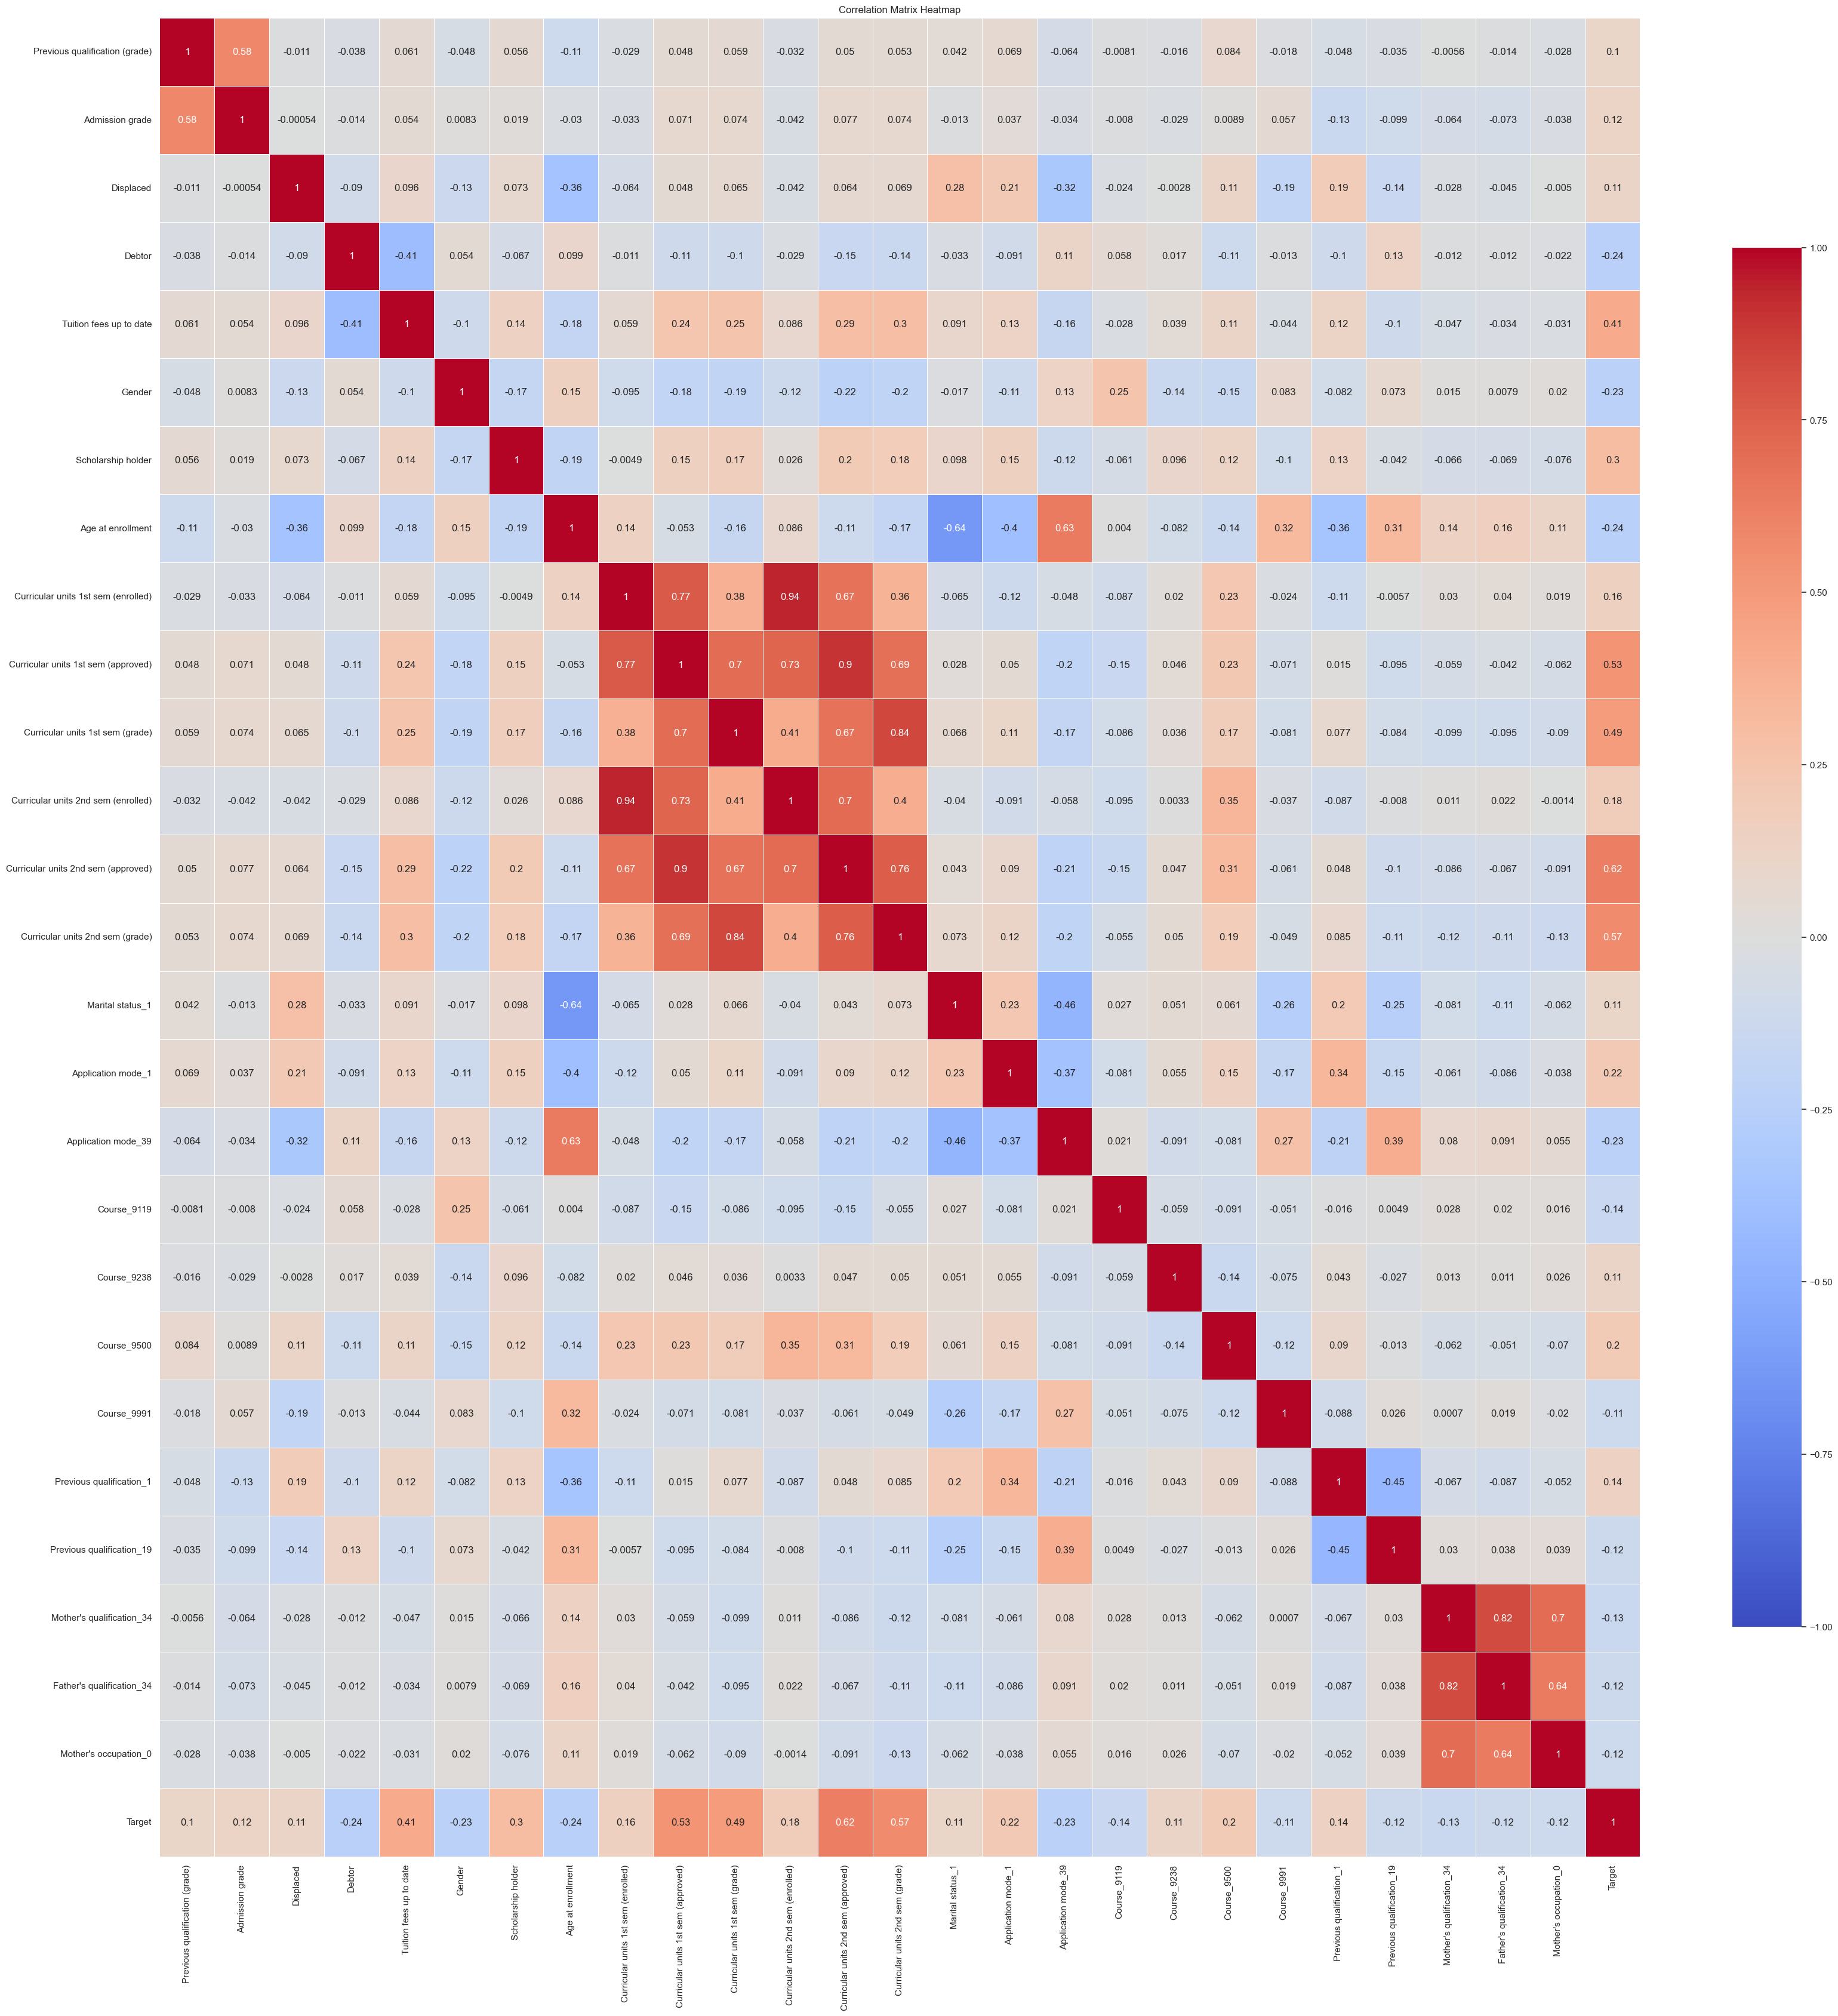

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

df_shortened = df_encoded[selected_features]
target_column = df_shortened.pop('Target')
df_shortened['Target'] = target_column


correlation_matrix_shortened = df_shortened.corr()


# Create the correlation heatmap
plt.figure(figsize=(40,40))
sns.set(font_scale=1.0)
heatmap = sns.heatmap(
    correlation_matrix_shortened,
    annot=True,
    cmap="coolwarm",
    vmin=-1, vmax=1,
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75}
)
plt.title("Correlation Matrix Heatmap")

plt.show()

In [78]:
# Generate a random forest model
X = df_encoded[selected_features].drop(['Target'], axis=1)
y = df_encoded['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Provide a classification report
y_pred = rf_model.predict(X_test)
print("\nClassification Report:")
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Classification Report:
0.7581920903954802
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       288
           1       0.62      0.31      0.42       177
           2       0.77      0.94      0.85       420

    accuracy                           0.76       885
   macro avg       0.72      0.67      0.68       885
weighted avg       0.74      0.76      0.74       885



In [80]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# Use StratifiedKFold for classification tasks
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=420)

k_fold_model = RandomForestClassifier()

# Specify multiple scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Perform cross-validation and calculate scores for each metric
cv_results = cross_validate(k_fold_model, X, y, cv=cv, scoring=scoring)

print("\nCross-Validation Results:")
for metric in ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']:
    print("{}: Mean {:.4f}, Std {:.4f}".format(
        metric.replace('test_', '').capitalize(),
        cv_results[metric].mean(),
        cv_results[metric].std()
    ))


Cross-Validation Results:
Accuracy: Mean 0.7713, Std 0.0154
Precision: Mean 0.7566, Std 0.0181
Recall: Mean 0.7713, Std 0.0154
F1: Mean 0.7578, Std 0.0162


In [86]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [25, 50, 100, 200],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'bootstrap': [True, False]
}

# Create the RandomForestClassifier
model = RandomForestClassifier()

# Create GridSearchCV
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=cv, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: {:.4f}".format(grid_search.best_score_))


Best Parameters:  {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 25}
Best Accuracy: 0.7821


In [87]:
# Provide a classification report
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)
print("\nClassification Report:")
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))




Classification Report:
0.751412429378531
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       288
           1       0.62      0.32      0.42       177
           2       0.77      0.94      0.84       420

    accuracy                           0.75       885
   macro avg       0.72      0.67      0.67       885
weighted avg       0.74      0.75      0.73       885

